# Strided TinyYOLOv3 sigma-delta network inference on GPU

This tutorial walks through the GPU inference of trained Strided TinyYOLOv3 SDNN and describe the lava-dl slayer object detection modules along the way.
* Refer to the [README](README.md) for the trainig script
* Refer to [PilotNet SDNN notebook](https://github.com/lava-nc/lava-dl/blob/main/tutorials/lava/lib/dl/slayer/pilotnet/train.ipynb) for an overview of Sigma-Delta networks.

## Object Detection module in Lava-DL
Lava-dl now includes object detection module which can be accessed as `from lava.lib.dl.slayer import obd` or as `slayer.obd`. The object detection module includes
* Base YOLO class `obd.yolo_base` which can be used to design and train YOLO SNNs.
* Pre-formulated model descriptions and pre-trained models `obd.models.{tiny_yolov3_str, yolo_kp}`. In this tutorial we will make use of Strided TinyYOLOv3 SDNN (`obd.models.tiny_yolov3_str`).
* Bounding box metrics and utilities `obd.bbox.{metrics, utils}` to facilitate video object detection training with spiking neurons.
* Dataset modules and utilities `obd.dataset.{BDD, utils}`. Currently there is support for [Berkley Deep Drive (BDD100K)](https://bdd-data.berkeley.edu/) dataset. More dataset support will be added in the future.

__Strided TinyYOLOv3 SDNN__: It is the Sigma-Delta version of TinyYOLOv3 object detection network designed to detect objects in a video stream. The network architecture is tweaked from the TinyYOLOv3[ref] architecture to make the best use of Loihi 2 architecture: the convolution + pool layers are replaced with strided convoltion. The model was trained using the `train_sdnn.py` script included in this folder with initial pre-training on COCO and final training on BDD100K dataset.
```bash
python train_sdnn [complete args]
```


In [1]:
import os
from datetime import datetime
import yaml

import torch
from torch.utils.data import DataLoader

from lava.lib.dl import slayer
from lava.lib.dl.slayer import obd

import ipyplot
import matplotlib.pyplot as plt
from matplotlib import animation, rcParams
import IPython.display as ipd

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from itertools import combinations

# Load Inference parameters

YOLO training involves a lot of hyperparameters. The training using `train_sdnn.py` exports training hyperparameter used during the training. `slayer.utils.dotdict` can be used to easily load the hyperparameters and use the same parameters in model fine-tuning as well as inference. In this tutorial we will see `model_args.<param>` being used at various places to initialize the model, dataset, dataloader and so on.

In [2]:
# inference_model = 'tiny_yolov3_str'  # Loihi compatible TinyYOLOv3 network
inference_model = 'yolo_kp'          # Customized model tragetted for 8 chip Kapoho Point form factor

args = slayer.utils.dotdict(load=f'Trained_{inference_model}/network.pt')
trained_folder = os.path.dirname(args.load)
print(trained_folder)

with open(trained_folder + '/args.txt', 'rt') as f:
    model_args = slayer.utils.dotdict(yaml.safe_load(f))
    for (k, v) in model_args.items():
        if k not in args.keys():
            args[k] = v
            
print('Using GPUs {}'.format(args.gpu))
device = torch.device('cuda:{}'.format(args.gpu[0]))
print()
print('Hyperparameters')
print('===============')
for k,v in args.items():
    print(f'{k} : {v}')
    
args.b = 1

Trained_yolo_kp
Using GPUs [0]

Hyperparameters
load : Trained_yolo_kp/network.pt
alpha_iou : 0.8
aug_prob : 0.4
b : 4
clamp_max : 5.0
clip : 1.0
dataset : BDD100K
epoch : 200
exp : None
gpu : [0]
label_smoothing : 0.03
lambda_cls : 1.0
lambda_coord : 2.0
lambda_iou : 2.25
lambda_noobj : 4.0
lambda_obj : 1.8
lr : 0.0001
lrf : 0.01
model : yolo_kp
num_workers : 12
output_dir : .
path : data/bdd100k
scale_grad : 0.2
seed : None
sp_lam : 0.01
sp_rate : 0.01
sparsity : True
subset : False
tau_grad : 0.1
tgt_iou_thr : 0.25
threshold : 0.1
track_iter : 100
verbose : False
warmup : 40
wd : 1e-05


# Load Network Parameters

In the following cell, we will
* Instanciate `obd.models.tiny_yolov3_str.Network` as the desired YOLO SDNN network
* Load the pretrained model parameters into the network

In [3]:
if inference_model == 'tiny_yolov3_str':
    Network = obd.models.tiny_yolov3_str.Network
elif inference_model == 'yolo_kp':
    Network = obd.models.yolo_kp.Network
else:
    raise RuntimeError

net = Network(threshold=model_args.threshold,
              tau_grad=model_args.tau_grad,
              scale_grad=model_args.scale_grad,
              num_classes=11,
              clamp_max=model_args.clamp_max).to(device)
net.init_model((448, 448))
# net.load_state_dict(torch.load(args.load))

# Create YOLO target

YOLO training requires target tensor generation. Lava-DL object detction module provides `obd.YOLOtarget` to generate the YOLO target for the network on the fly. `obd.YOLOtarget` also includes `collate_fn` method which can be used to stack the samples, targets and ground truth bounding boxes in the dataloader.

In [4]:
yolo_target = obd.YOLOtarget(anchors=net.anchors,
                             scales=net.scale,
                             num_classes=net.num_classes,
                             ignore_iou_thres=model_args.tgt_iou_thr)

# Load Dataset and Dataloader

Here we will make use of `obd.dataset.BDD` to create the required dataset for BDD100K inference. The dataloader is the standard PyTorch dataloader instance. Note the use of `yolo_target.collate_fn` to generate traget YOLO tensors and describe the batch samples stacking strategy.

In [5]:
args.path = "/home/lecampos/data/bdd100k"
test_set = obd.dataset.BDD(root=args.path, dataset='track', train=False, randomize_seq=False, seq_len=200)

test_loader = DataLoader(test_set,
                         batch_size=args.b,
                         shuffle=True,
                         collate_fn=yolo_target.collate_fn,
                         num_workers=4,
                         pin_memory=True)

# Run GPU Inference

GPU inferene of the network follows the standard PyTorch testing iteration through the test_set once. We make use of `obd.bbox.metrics.APstats` module to evaluate mean Averge Precision (mAP) performance of the YOLO SDNN network.

Note the redifinition of accuracy string in `slayer.utils.LearningStats` and it's use in printing the progress interactively.

In [7]:
import random
from collections import defaultdict, deque
# Assuming latent_space_extractor is your model that outputs latent space vectors
# and dataloader is your DataLoader object
latent_vectors = []
labels = []
max_samples_per_class = 1000  # Set a limit for samples per class to cap memory usage
num_classes = 11
class_counters = defaultdict(int)
reservoir = defaultdict(deque)

epoch = 0
stats = slayer.utils.LearningStats(accuracy_str='AP@0.5')
t_st = datetime.now()
ap_stats = obd.bbox.metrics.APstats(iou_threshold=0.5)

# Function to add sample to reservoir
def add_sample_to_reservoir(latent_vector, label, class_counters, reservoir):
    label = label.item()
    if class_counters[label] < max_samples_per_class:
        reservoir[label].append(latent_vector)
        class_counters[label] += 1
    else:
        # Replace an existing sample with a new one to maintain the reservoir size
        idx_to_replace = random.randint(0, max_samples_per_class - 1)
        reservoir[label][idx_to_replace] = latent_vector

# Function to check if the reservoir is full for all classes
def is_reservoir_full(class_counters, max_samples_per_class, num_classes):
    return all(count >= max_samples_per_class for count in class_counters.values()) and len(class_counters) >= num_classes


for i, (inputs, targets, bboxes) in enumerate(test_loader):
    net.eval()

    with torch.no_grad():
        print('inputs ', inputs.shape)
        inputs = inputs.to(device)
        predictions, counts, latent_space = net(inputs, latent_space_backcounter=1)
        T = inputs.shape[-1]
        predictions = [obd.bbox.utils.nms_ls(predictions[..., t], latent_space[..., t]) for t in range(T)]
        print("predictions time step", len(predictions))
        for t in range(T):
            for batch in range(args.b):
                for idx in  range(predictions[t][batch]['detections'].shape[0]):
                    lv = predictions[t][batch]['latent'][idx]
                    target = predictions[t][batch]['detections'][idx][[5]]
                    add_sample_to_reservoir(lv, target, class_counters, reservoir)

                    # latent_vectors.append(predictions[t][batch]['latent'][[idx]])
                    # labels.append(predictions[t][batch]['detections'][idx][[5]])
    print(torch.cuda.memory_allocated()/1024**2)
    print(class_counters.values())
    if is_reservoir_full(class_counters, max_samples_per_class, num_classes) or i>40:
        break


inputs  torch.Size([1, 3, 448, 448, 200])
predictions time step 200
827.4462890625
dict_values([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 894, 220, 91])
inputs  torch.Size([1, 3, 448, 448, 200])
predictions time step 200
941.4931640625
dict_values([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 272, 112])
inputs  torch.Size([1, 3, 448, 448, 200])
predictions time step 200
1040.30859375
dict_values([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 430, 128])
inputs  torch.Size([1, 3, 448, 448, 200])
predictions time step 200
1109.6484375
dict_values([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 508, 142])
inputs  torch.Size([1, 3, 448, 448, 200])
predictions time step 200
1153.5009765625
dict_values([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 744, 263])
inputs  torch.Size([1, 3, 448, 448, 200])
predictions time step 200
1245.33154296875
dict_values([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 761, 271])
inputs  torch.Size([1, 3, 448, 448, 

In [15]:
# Convert reservoir to lists of latent vectors and labels
balanced_latent_vectors = []
balanced_labels = []

for label, latent_list in reservoir.items():
    balanced_latent_vectors.extend(latent_list)
    balanced_labels.extend([label] * len(latent_list))

# Convert lists to tensors
latent_vectors = torch.stack(balanced_latent_vectors).cpu().numpy()
labels = torch.tensor(balanced_labels).cpu().numpy()


# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(latent_vectors.cpu(), labels.cpu())

In [ ]:
# delete network to free up space
del net
torch.cuda.empty_cache()

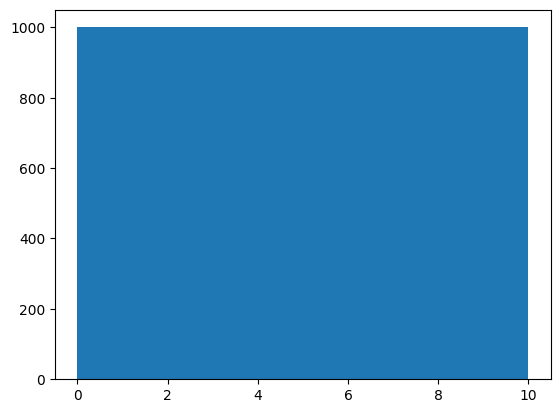

In [ ]:
# check # of samples per class
plt.hist(labels,11)
plt.show()

unique_labels,counts= np.unique(labels, return_counts=True)
print(counts)

In [32]:
X_tsne = TSNE(n_components=2, learning_rate='auto', n_jobs=-1, n_iter_without_progress=200, 
              verbose=2,init='pca', perplexity=counts[0]/100, 
              n_iter=2000, metric='cosine').fit_transform(latent_vectors[::10,])

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 11000 samples in 0.004s...
[t-SNE] Computed neighbors for 11000 samples in 2.800s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11000
[t-SNE] Computed conditional probabilities for sample 2000 / 11000
[t-SNE] Computed conditional probabilities for sample 3000 / 11000
[t-SNE] Computed conditional probabilities for sample 4000 / 11000
[t-SNE] Computed conditional probabilities for sample 5000 / 11000
[t-SNE] Computed conditional probabilities for sample 6000 / 11000
[t-SNE] Computed conditional probabilities for sample 7000 / 11000
[t-SNE] Computed conditional probabilities for sample 8000 / 11000
[t-SNE] Computed conditional probabilities for sample 9000 / 11000
[t-SNE] Computed conditional probabilities for sample 10000 / 11000
[t-SNE] Computed conditional probabilities for sample 11000 / 11000
[t-SNE] Mean sigma: 0.123883
[t-SNE] Computed conditional probabilities in 0.764s
[t-SNE] Iteration 50: error = 77.96

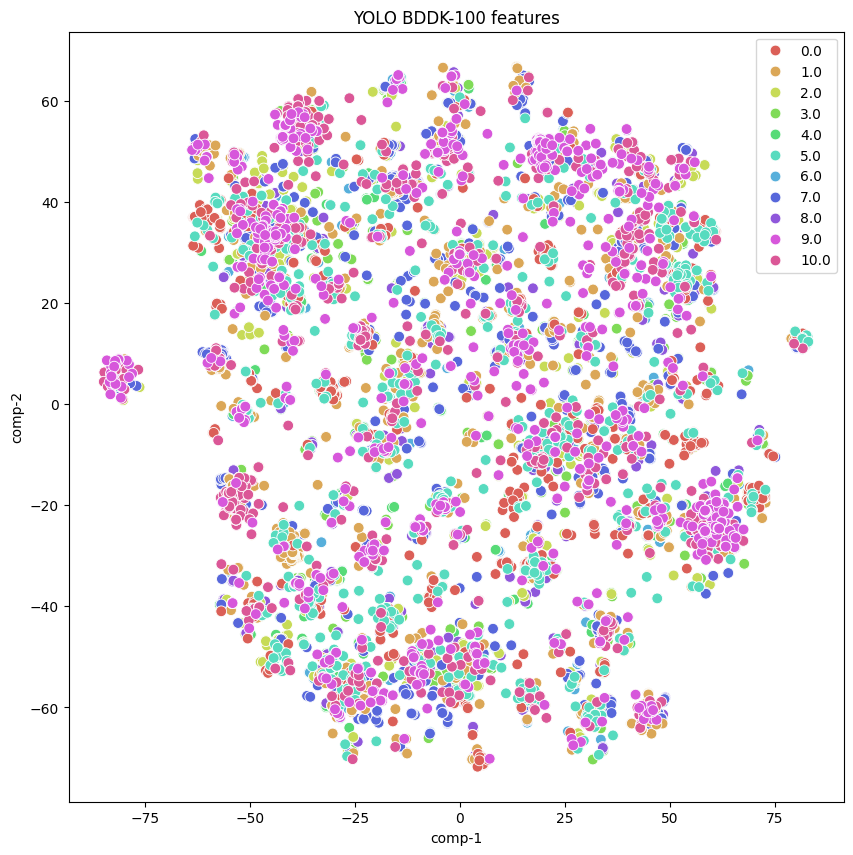

In [33]:
num_classes = len(unique_labels)

df = pd.DataFrame()
df["y"] = labels[::10]
df["comp-1"] = X_tsne[:,0]
df["comp-2"] = X_tsne[:,1]


# df_train = df_train.iloc[np.argsort(y_u_train),:]
plt.figure(figsize=(10,10))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), s=60,
                palette=sns.color_palette("hls", num_classes),legend=True,
                data=df).set(title="YOLO BDDK-100 features") 
ax=plt.gca()


a = pd.concat({'x': df["comp-1"], 'y': df["comp-2"], 'label': df["y"]}, axis=1)

In [14]:
# # Save extracted features
# latent_vectors = latent_vectors/ (np.linalg.norm(latent_vectors, axis=1, keepdims=True))
# np.savez('yolo_bdd_normed_features.npz', X=latent_vectors, y=labels)

In [6]:
# Load the arrays from the .npz file
loaded_data = np.load('data/yolo_bdd_normed_features.npz')

# Access the arrays
latent_vectors = loaded_data['X']
labels = loaded_data['y']

# # Convert to 7-bit optionally, but this degrades the performance only a little
# latent_vectors = (latent_vectors*2**7).astype(np.int32)

In [117]:
# Define the classes you want to keep
classes_to_keep = [0,3,6,7]

# Create a boolean mask that is True for the desired classes
mask = np.isin(labels, classes_to_keep)

# Filter X_train and y_train using the mask
latent_vectors = latent_vectors[mask,]
labels = labels[mask]

In [7]:
k_ss = 2 

latent_vectors = latent_vectors[::k_ss,:]
labels = labels[::k_ss]

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from cuml.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score

n_splits = 1
num_classes = len(np.unique(labels))

accs = np.zeros(shape=(n_splits,5))



# X_resampled = X_resampled/ (np.linalg.norm(X_resampled, axis=1, keepdims=True))

sss = StratifiedShuffleSplit(n_splits=n_splits, train_size=0.8, random_state=111)


for i, (train_inds, test_inds) in enumerate(sss.split(latent_vectors, labels)):
    X_train = latent_vectors[train_inds,:]
    y_train = labels[train_inds]
    X_test = latent_vectors[test_inds,:]
    y_test = labels[test_inds]

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    ## ------------------------------------
    # clf = LinearSVC()
    # # clf = SVC(kernel='linear')
    # clf.fit(X_train, y_train)
    # y_pred=clf.predict(X_test)
    # accs[i,0] = metrics.accuracy_score(y_test, y_pred)

    # report = classification_report(y_test, y_pred)
    # print(report)   

    # # print("Balanced acc: ", balanced_accuracy_score(y_test, y_pred))

    # clf = svm.SVC(max_iter=10000, kernel='rbf', gamma=0.01, C=1)
    # clf.fit(X_train, y_train)
    # y_pred=clf.predict(X_test)
    # accs[i,1] = metrics.accuracy_score(y_test, y_pred)

    # report = classification_report(y_test, y_pred)
    # print(report)   
    # # print(clf.n_support_)

    # clf = NearestCentroid(metric='cosine')
    # clf.fit(X_train, y_train)
    # y_pred=clf.predict(X_test)
    # accs[i,2] = metrics.accuracy_score(y_test, y_pred)

    clf = KNeighborsClassifier(n_neighbors=1, n_jobs=8, metric='cosine')
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    accs[i,3] = metrics.accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(report)   

    # clf = MLPClassifier(random_state=1,hidden_layer_sizes=(128,), max_iter=1000).fit(X_train, y_train)
    # y_pred=clf.predict(X_test)
    # accs[i,4] = metrics.accuracy_score(y_test, y_pred)
    # report = classification_report(y_test, y_pred)
    # print(report)   

    print("Split ", i, " done")

              precision    recall  f1-score   support

         0.0       0.47      0.48      0.48       100
         1.0       0.43      0.45      0.44       100
         2.0       0.59      0.60      0.59       100
         3.0       0.43      0.43      0.43       100
         4.0       0.90      0.80      0.85       100
         5.0       0.46      0.42      0.44       100
         6.0       0.54      0.62      0.58       100
         7.0       0.80      0.66      0.72       100
         8.0       0.60      0.58      0.59       100
         9.0       0.61      0.60      0.60       100
        10.0       0.44      0.52      0.48       100

    accuracy                           0.56      1100
   macro avg       0.57      0.56      0.56      1100
weighted avg       0.57      0.56      0.56      1100

Split  0  done


In [124]:
np.mean(accs, axis=0)*100, np.std(accs, axis=0)*100

(array([41.5, 43. , 38. , 45. ,  0. ]),
 array([3.39116499, 6.96419414, 4.30116263, 5.24404424, 0.        ]))

In [9]:
class_labels = np.unique(y_test)
class_accuracies = [np.mean(y_pred[y_test == cls] == cls) for cls in class_labels]
print(class_accuracies)

[0.48, 0.45, 0.6, 0.43, 0.8, 0.42, 0.62, 0.66, 0.58, 0.6, 0.52]


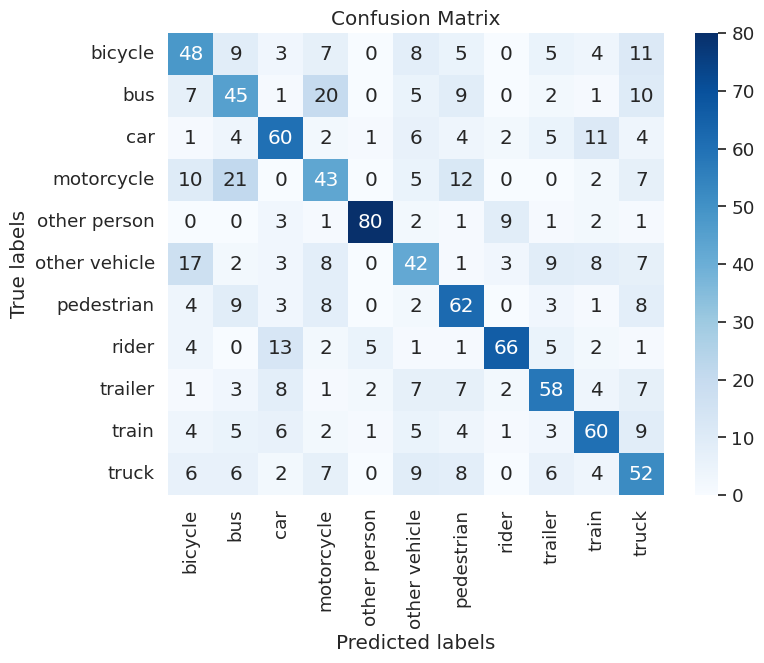

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
class_names = np.array(test_set.classes)[np.unique(labels).astype(int)]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size

# Create heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

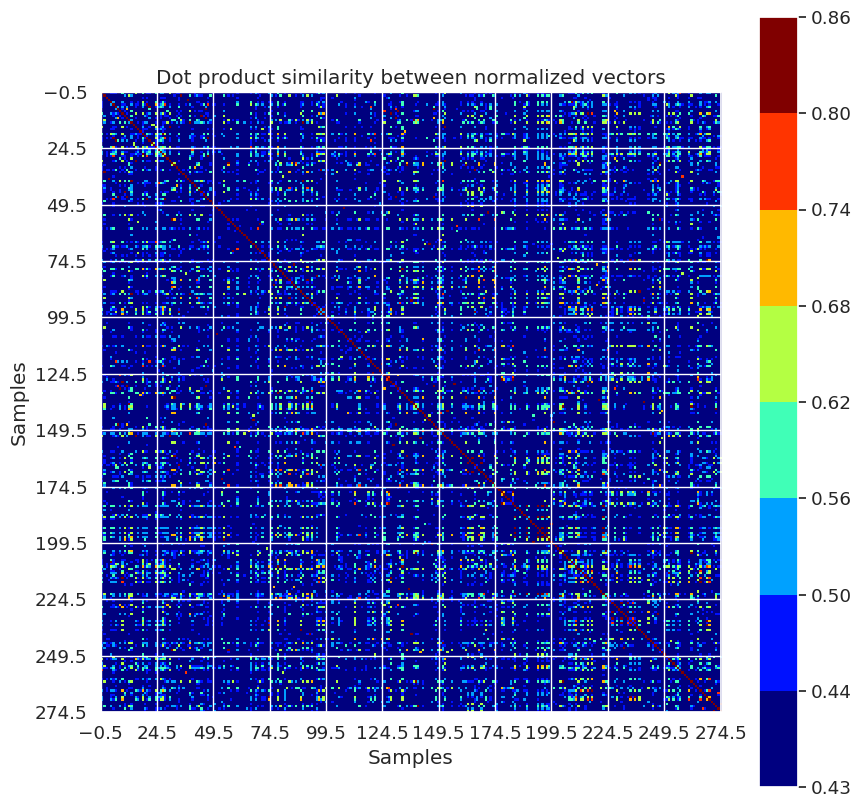

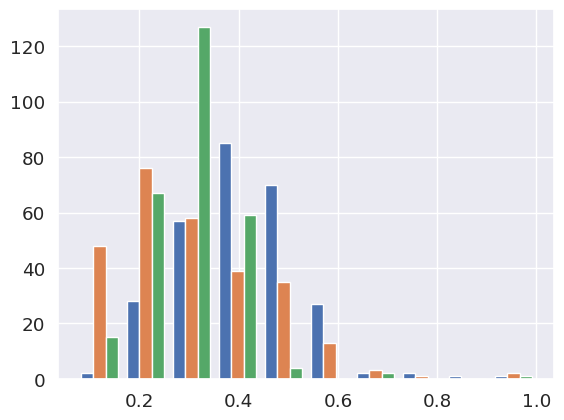

In [35]:
# Feature similarities between all classes (subsampled)

k_ss = 20
num_classes = len(np.unique(labels))

sorted_features = latent_vectors[np.argsort(labels),:]
sorted_labels = labels[np.argsort(labels)]

ss_features = sorted_features[::k_ss,:]
ss_labels = sorted_labels[::k_ss]

normed_features = ss_features/ (np.linalg.norm(ss_features, axis=1, keepdims=True))

sims = np.matmul(normed_features,normed_features.T)
# sorted_sims = torch.cdist(sorted_features,sorted_features).cpu()


from matplotlib import colors


a_in = [0.43]+list(np.arange(0.44,0.91, 0.06))

# define the colormap
cmap = plt.cm.jet  

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

bounds=a_in
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(10,10))
img = plt.imshow(sims, interpolation='nearest',cmap=cmap, norm=norm)
plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=a_in)
plt.title("Dot product similarity between normalized vectors")
plt.xlabel("Samples")
plt.ylabel("Samples")

spacing = sims.shape[0]/num_classes
plt.xticks(np.arange(-0.5, sims.shape[1] + 1, spacing))
plt.yticks(np.arange(-0.5, sims.shape[0] + 1, spacing))
plt.grid(which='both', color='white', linestyle='-', linewidth=1)
# plt.xticks(np.arange(1, sims.shape[1] + 1, spacing))
# plt.yticks(np.arange(1, sims.shape[0] + 1, spacing))

plt.show()

plt.figure()
plt.hist(sims[:,20:23])
plt.show()

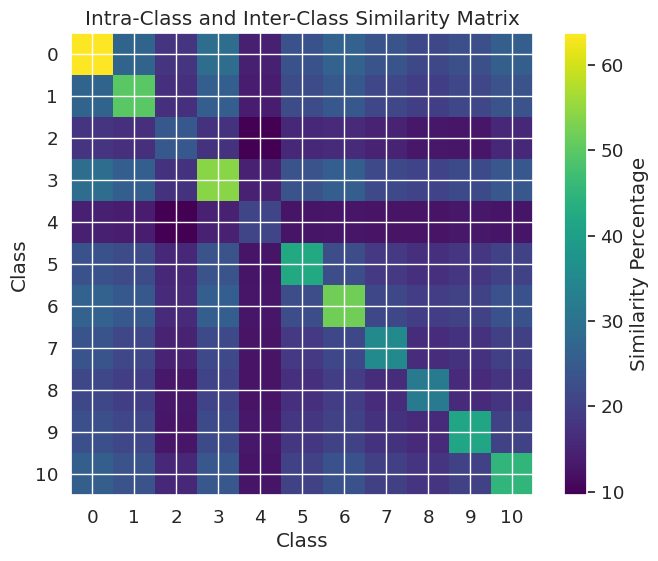

In [19]:
# Average of the similarities passing threshold, for each intra-class and inter-class pairs

k_ss =2

X = latent_vectors
y = labels.astype(int)

X = X[::k_ss,:]
y = y[::k_ss]

# Function to compute dot product similarity
# Function to compute dot product similarity
def dot_product_similarity(A, B):
    return np.dot(A, B.T)

# Define the similarity threshold
similarity_threshold = 0.44

unique_classes = np.unique(y)
class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
n_classes = len(unique_classes)

# Initialize matrix to hold the similarities
similarity_matrix = np.zeros((n_classes, n_classes))

# Compute intra-class similarity above the threshold
for class_label in unique_classes:
    class_samples = X[y == class_label]
    if len(class_samples) > 1:
        similarities = dot_product_similarity(class_samples, class_samples)
        # Exclude self-similarity (diagonal elements)
        num_similar_pairs = np.sum((similarities > similarity_threshold) & ~np.eye(len(similarities), dtype=bool))
        total_pairs = len(class_samples) * (len(class_samples) - 1) / 2
        if total_pairs > 0:
            similarity_percentage = num_similar_pairs / total_pairs * 100
        else:
            similarity_percentage = 0
        similarity_matrix[class_to_index[class_label], class_to_index[class_label]] = similarity_percentage

# Compute inter-class similarity above the threshold
for class1, class2 in combinations(unique_classes, 2):
    class1_samples = X[y == class1]
    class2_samples = X[y == class2]
    similarities = dot_product_similarity(class1_samples, class2_samples)
    num_similar_pairs = np.sum(similarities > similarity_threshold)
    total_pairs = len(class1_samples) * len(class2_samples)
    if total_pairs > 0:
        similarity_percentage = num_similar_pairs / total_pairs * 100
    else:
        similarity_percentage = 0
    similarity_matrix[class_to_index[class1], class_to_index[class2]] = similarity_percentage
    similarity_matrix[class_to_index[class2], class_to_index[class1]] = similarity_percentage

# Plot the matrix using imshow
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Similarity Percentage')
plt.title('Intra-Class and Inter-Class Similarity Matrix')
plt.xlabel('Class')
plt.ylabel('Class')

# Add class labels to the axes
plt.xticks(ticks=np.arange(n_classes), labels=unique_classes)
plt.yticks(ticks=np.arange(n_classes), labels=unique_classes)

# Show the plot
plt.show()

In [20]:
# Trying to make a trade-off between class-wise accuracies and intra-class variablity

intra_vars = similarity_matrix.diagonal()
intra_vars = intra_vars /np.max(intra_vars)
(class_accuracies+intra_vars)/2


array([0.74      , 0.61647756, 0.49193142, 0.63870146, 0.56394352,
       0.54323248, 0.71771558, 0.6088704 , 0.54179022, 0.62622289,
       0.61431165])

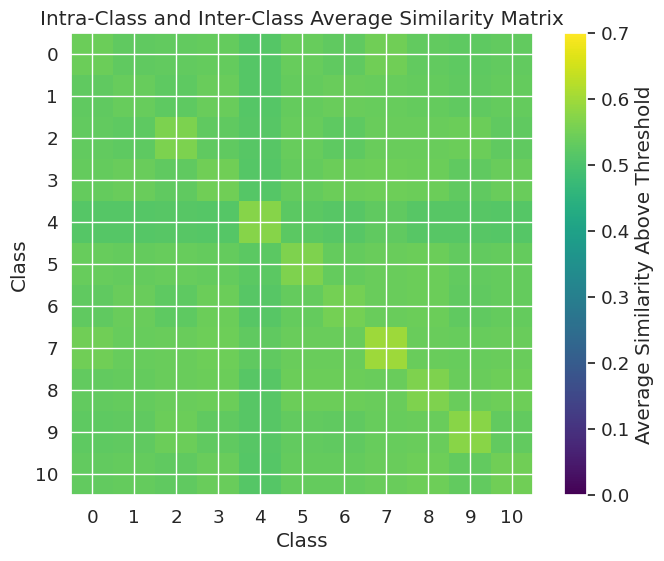

In [26]:
# Average of the similarities for each intra-class and inter-class pairs

k_ss =2

X = latent_vectors
y = labels.astype(int)

X = X[::k_ss,:]
y = y[::k_ss]


def dot_product_similarity(A, B):
    return np.dot(A, B.T)

# Define the similarity threshold
similarity_threshold = 0.44

# Map class labels to a contiguous range
unique_classes = np.unique(y)
class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
n_classes = len(unique_classes)

# Initialize matrix to hold the similarities
similarity_matrix = np.zeros((n_classes, n_classes))

# Compute intra-class average similarity above the threshold
for class_label in unique_classes:
    class_samples = X[y == class_label]
    if len(class_samples) > 1:
        similarities = dot_product_similarity(class_samples, class_samples)
        # Exclude self-similarity (diagonal elements)
        similarities = similarities[~np.eye(similarities.shape[0], dtype=bool)]
        # Filter similarities above the threshold
        above_threshold = similarities[similarities > similarity_threshold]
        if len(above_threshold) > 0:
            average_similarity = np.mean(above_threshold)
        else:
            average_similarity = 0
        similarity_matrix[class_to_index[class_label], class_to_index[class_label]] = average_similarity

# Compute inter-class average similarity above the threshold
for class1, class2 in combinations(unique_classes, 2):
    class1_samples = X[y == class1]
    class2_samples = X[y == class2]
    similarities = dot_product_similarity(class1_samples, class2_samples)
    # Filter similarities above the threshold
    above_threshold = similarities[similarities > similarity_threshold]
    if len(above_threshold) > 0:
        average_similarity = np.mean(above_threshold)
    else:
        average_similarity = 0
    similarity_matrix[class_to_index[class1], class_to_index[class2]] = average_similarity
    similarity_matrix[class_to_index[class2], class_to_index[class1]] = average_similarity

# Define the range for the colormap
vmin = 0  # minimum value for the color map
vmax = 0.7  # maximum value for the color map

# Plot the matrix using imshow
plt.figure(figsize=(8, 6))
im = plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im)
cbar.set_label('Average Similarity Above Threshold')
plt.title('Intra-Class and Inter-Class Average Similarity Matrix')
plt.xlabel('Class')
plt.ylabel('Class')

# Add class labels to the axes
plt.xticks(ticks=np.arange(n_classes), labels=unique_classes)
plt.yticks(ticks=np.arange(n_classes), labels=unique_classes)

# Show the plot
plt.show()

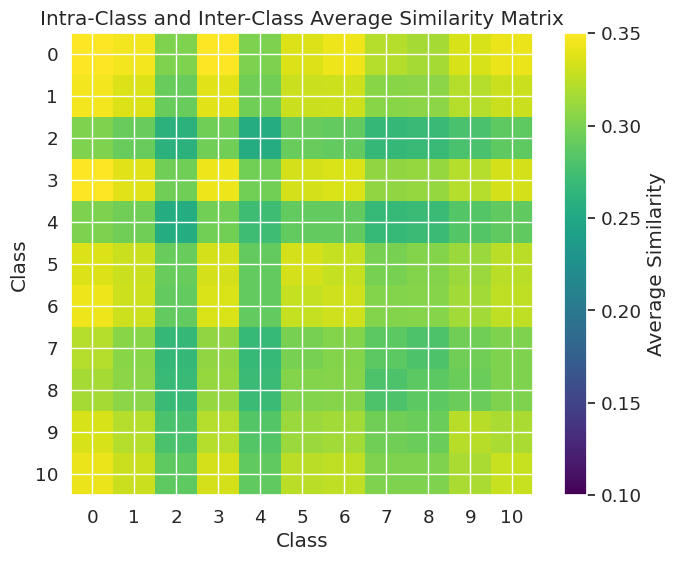

In [27]:
# Percentage of similarities per intra- and inter-class that passes the threshold

k_ss =2

X = latent_vectors
y = labels.astype(int)

X = X[::k_ss,:]
y = y[::k_ss]

# Function to compute dot product similarity
def dot_product_similarity(A, B):
    return np.dot(A, B.T)

# Map class labels to a contiguous range
unique_classes = np.unique(y)
class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
n_classes = len(unique_classes)

# Initialize matrix to hold the similarities
similarity_matrix = np.zeros((n_classes, n_classes))

# Compute intra-class average similarity
for class_label in unique_classes:
    class_samples = X[y == class_label]
    if len(class_samples) > 1:
        similarities = dot_product_similarity(class_samples, class_samples)
        # Exclude self-similarity (diagonal elements)
        similarities = similarities[~np.eye(similarities.shape[0], dtype=bool)]
        average_similarity = np.mean(similarities)
        similarity_matrix[class_to_index[class_label], class_to_index[class_label]] = average_similarity

# Compute inter-class average similarity
for class1, class2 in combinations(unique_classes, 2):
    class1_samples = X[y == class1]
    class2_samples = X[y == class2]
    similarities = dot_product_similarity(class1_samples, class2_samples)
    average_similarity = np.mean(similarities)
    similarity_matrix[class_to_index[class1], class_to_index[class2]] = average_similarity
    similarity_matrix[class_to_index[class2], class_to_index[class1]] = average_similarity

# Plot the matrix using imshow
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest', vmin=0.10, vmax=0.35)
plt.colorbar(label='Average Similarity')
plt.title('Intra-Class and Inter-Class Average Similarity Matrix')
plt.xlabel('Class')
plt.ylabel('Class')

# Add class labels to the axes
plt.xticks(ticks=np.arange(n_classes), labels=unique_classes)
plt.yticks(ticks=np.arange(n_classes), labels=unique_classes)

# Show the plot
plt.show()


In [33]:
np.array([7000, 7100, 8100, 9100, 10100, 11100, 12100, 13100, 14100])/2**14

array([0.42724609, 0.43334961, 0.49438477, 0.55541992, 0.61645508,
       0.67749023, 0.73852539, 0.79956055, 0.8605957 ])

# Visualize results

The lava-dl object detection module also provides visualization utilities which can be used to create video frames and animations of the network output.
* `obd.bbox.utils.mark_bounding_boxes` to mark bounding box to image.
* `obd.bbox.utils.create_frames` to create annotated image frames for a sequence of predictions and ground truth.
* `obd.bbox.utils.create_video` to export the annotated video for a sequence of predictions and ground truth.


In [ ]:
# Visualize a few frames
# obd.bbox.utils.create_video(inputs, bboxes, predictions, 'yolo_output', test_set.classes)
frames = obd.bbox.utils.create_frames(inputs, bboxes, predictions, test_set.classes)
fig, ax = plt.subplots(figsize=(6, 3))
img_plt = ax.imshow(frames[0])
ax.axis('off')

rcParams['animation.embed_limit'] = 1<<20
anim = animation.FuncAnimation(fig, lambda i: img_plt.set_data(frames[i]),
                               frames=len(frames), interval=40, repeat=True)
plt.close(fig)

num_frames = 5
fig, ax = plt.subplots(num_frames, 1, figsize=(8, 4 * num_frames))
for i in range(num_frames):
    ax[i].imshow(frames[i])
    ax[i].axis('off')
    ax[i].set_title(f'Frame {i}')

TypeError: list indices must be integers or slices, not tuple

In [ ]:
# Visualize video
anim.save('yolo_output.mp4', writer=animation.FFMpegWriter())
ipd.Video('yolo_output.mp4')